## Problem  Statement

Dota2 is a free-to-play multiplayer online battle arena (MOBA) video game. Dota 2 is played in matches between two teams of five players, with each team occupying and defending their own separate base on the map. Each of the ten players independentlycontrols a powerful character, known as a "hero" (which they choose at the start of the match), who all have unique abilities and differing styles of play. During a match, players collect experience points and items for their heroes to successful battle with the opposing team's heroes, who attempt to do the same to them. A team wins by being the first to destroy a large structure located in the opposing team's base, called the "Ancient".

You’re given dataset of professional Dota players and their most frequent 10 heroes. The data also includes details about the heros (Kind of Hero (nuker, initiator and so on), their base attack, strength, movement speed). Here both train and test dataset is divided into two dataset(train9.csv & train1.csv and test9.csv & test1.csv).

train9.csv and train1.csv contain the user performance for their most frequent 9 heroes and 10th hero respectively. Both train9.csv and train1.csv have below fields.
 

### Feature------------------------Description

    user_id              The id of the user

    hero_id              The id of the hero the player played with

    id                   Unique id

    num_games            The number of games the player played with that hero

    num_wins             Number of games the player won with this particular hero

    kda_ratio (target)   ((Kills + Assists)*1000/Deaths) 

                         Ratio: where kill, assists and deaths are average values per match for that hero



test9.csv contain the different set of user (different from training set) performance for their most frequent 9 heroes. test9.csv has similar fields as train9.csv. Now, the aim is to predict the performance (kda_ratio) of the same set of users (test users) with the 10th hero which is test1.csv.


### Feature-----------------------------Description

    user_id                  The id of the user

    hero_id                  The id of the hero (of which the kda_ratio has to be predicted)

    id                       Unique id

    num_games                The total number of games the player played with this hero

 

We also have "hero_data.csv" which contains information about heros.


### Feature---------------------------------------Description

    hero_id                         Id of the hero

    primary_attr                    A string denoting what the primary attribute of the hero is
                                    (int- initiator, agi- agility, str- strength and so on)

    attack_type                     String, :”Melee“ or “Ranged”

    roles                           An array of strings which have roles of heroes
                                    (eg Support, Disabler, Nuker, etc.)

    base_health                     The basic health the hero starts with

    base_health_regen,base_mana,    These are the basic stats the heroes start with                                
    base_mana_regen,base_armor,     (some remain same throughout the game)
    base_magic_restistance,
    base_attack_min,base_attack_max,
    base_strength,base_agility,
    base_intelligence,
    strength_gain,agility_gain,
    intelligence_gain,
    attack_range,projectile_speed,
    attack_rate,move_speed,turn_rate
	

 
Evaluation Metric

The predictions will be evaluated on RMSE.

The public private split is 40:60

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


### Load the datasets.

In [2]:
#loading datasets

heroes_df = pd.read_csv(r'H:/py/datasets/av/dota/hero_data.csv', index_col=['hero_id'])
train1 = pd.read_csv('H:/py/datasets/av/dota/train1.csv')
train9 = pd.read_csv('H:/py/datasets/av/dota/train9.csv')
test1 = pd.read_csv('H:/py/datasets/av/dota/test1.csv')
test9 = pd.read_csv('H:/py/datasets/av/dota/test9.csv')

In [3]:
#basic info

heroes_df.info()
train1.info()
train9.info()
test1.info()
test9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 1 to 120
Data columns (total 22 columns):
primary_attr             115 non-null object
attack_type              115 non-null object
roles                    115 non-null object
base_health              115 non-null int64
base_health_regen        115 non-null float64
base_mana                115 non-null int64
base_mana_regen          115 non-null float64
base_armor               115 non-null float64
base_magic_resistance    115 non-null int64
base_attack_min          115 non-null int64
base_attack_max          115 non-null int64
base_strength            115 non-null int64
base_agility             115 non-null int64
base_intelligence        115 non-null int64
strength_gain            115 non-null float64
agility_gain             115 non-null float64
intelligence_gain        115 non-null float64
attack_range             115 non-null int64
projectile_speed         115 non-null int64
attack_rate              115 non-null float6

In [4]:
#features

print(heroes_df.columns)
print(train1.columns)
print(train9.columns)
print(test1.columns)
print(test9.columns)

Index(['primary_attr', 'attack_type', 'roles', 'base_health',
       'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
       'base_magic_resistance', 'base_attack_min', 'base_attack_max',
       'base_strength', 'base_agility', 'base_intelligence', 'strength_gain',
       'agility_gain', 'intelligence_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate'],
      dtype='object')
Index(['user_id', 'hero_id', 'id', 'num_games', 'num_wins', 'kda_ratio'], dtype='object')
Index(['user_id', 'hero_id', 'id', 'num_games', 'num_wins', 'kda_ratio'], dtype='object')
Index(['user_id', 'hero_id', 'id', 'num_games'], dtype='object')
Index(['user_id', 'hero_id', 'id', 'num_games', 'num_wins', 'kda_ratio'], dtype='object')


In [5]:
heroes_df.drop('roles', inplace=True, axis=1)

### Check if label is normally distributed

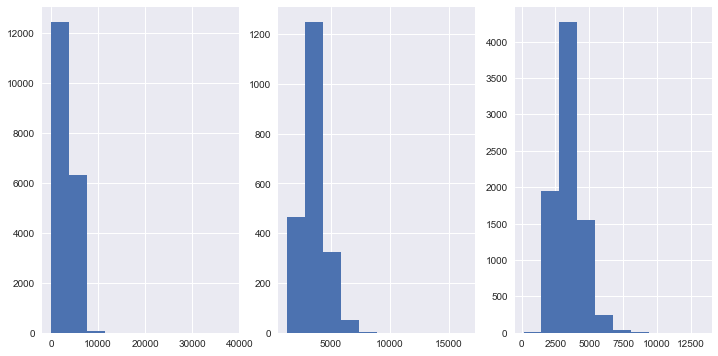

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 6))



ax1.hist(train9['kda_ratio'])
ax2.hist(train1['kda_ratio'])
ax3.hist(test9['kda_ratio'])
plt.show()

### Training sets are right skewed but test set is approximately normal.

### We need to add hero features to  all dataframes. We also need mean user performance and mean hero performance. Use all dataframes for hero performance and respective dataframes for user performance

In [7]:
#Creating these features

heroperform = pd.concat([train9, test9, train1]).groupby('hero_id')['kda_ratio'].mean()

userperformtr = train9.groupby('user_id')['kda_ratio'].mean()
userperformts = test9.groupby('user_id')['kda_ratio'].mean()

In [8]:
#adding these new features to our dataframes

train9['hperform'] = train9['hero_id'].map(heroperform)
train9['uperform'] = train9['user_id'].map(userperformtr)

train1['hperform'] = train1['hero_id'].map(heroperform)
train1['uperform'] = train1['user_id'].map(userperformtr)

test9['hperform'] = test9['hero_id'].map(heroperform)
test9['uperform'] = test9['user_id'].map(userperformts)

test1['hperform'] = test1['hero_id'].map(heroperform)
test1['uperform'] = test1['user_id'].map(userperformts)


# add hero features

def add_feat(df):
    for i in heroes_df.columns.values:
        df[i] = df['hero_id'].map(heroes_df[i])
        
add_feat(train9)
add_feat(train1)
add_feat(test9)
add_feat(test1)        

In [9]:
#one hot encoding

train9 = pd.get_dummies(train9, columns=['primary_attr', 'attack_type'], drop_first=True)
train1 = pd.get_dummies(train1, columns=['primary_attr', 'attack_type'], drop_first=True)
test9 = pd.get_dummies(test9, columns=['primary_attr', 'attack_type'], drop_first=True)
test1 = pd.get_dummies(test1, columns=['primary_attr', 'attack_type'], drop_first=True)

### Check all the features

In [10]:
#check features
print(heroes_df.columns)
print(train1.columns)
print(train9.columns)
print(test1.columns)
print(test9.columns)

Index(['primary_attr', 'attack_type', 'base_health', 'base_health_regen',
       'base_mana', 'base_mana_regen', 'base_armor', 'base_magic_resistance',
       'base_attack_min', 'base_attack_max', 'base_strength', 'base_agility',
       'base_intelligence', 'strength_gain', 'agility_gain',
       'intelligence_gain', 'attack_range', 'projectile_speed', 'attack_rate',
       'move_speed', 'turn_rate'],
      dtype='object')
Index(['user_id', 'hero_id', 'id', 'num_games', 'num_wins', 'kda_ratio',
       'hperform', 'uperform', 'base_health', 'base_health_regen', 'base_mana',
       'base_mana_regen', 'base_armor', 'base_magic_resistance',
       'base_attack_min', 'base_attack_max', 'base_strength', 'base_agility',
       'base_intelligence', 'strength_gain', 'agility_gain',
       'intelligence_gain', 'attack_range', 'projectile_speed', 'attack_rate',
       'move_speed', 'turn_rate', 'primary_attr_int', 'primary_attr_str',
       'attack_type_Ranged'],
      dtype='object')
Index(['use

### check correlation between features

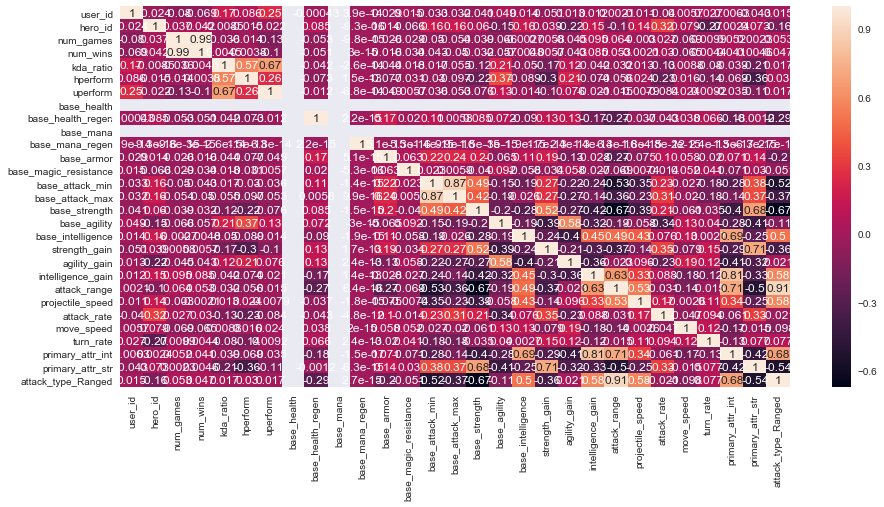

In [11]:
cor = pd.concat([train9, train1, test9]).corr()
fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(cor, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [12]:
#top features

top_features = cor[cor['kda_ratio'] > 0.001].index.values
print(top_features)

['user_id' 'num_wins' 'kda_ratio' 'hperform' 'uperform' 'base_agility'
 'agility_gain' 'projectile_speed' 'move_speed' 'attack_type_Ranged']


### Num wins is an important feature but it is highly correlated with num games. Also after creating this feature for test1 the score worsened.
### So do not use num wins for training models
 

### Train a model with training set 9 and check the performance with training set 1. Use these features to create a model for testing set 9 which will be used to predict for testing set 1.

In [13]:
#function for gridsearch

from sklearn.model_selection import GridSearchCV

def tune(data, features, label, model, params):
    gscv = GridSearchCV(estimator=model,param_grid=params, n_jobs=-1, cv=10, scoring='neg_mean_squared_error')
    gscv.fit(data[features], data[label])
    print(gscv.best_score_, gscv.best_estimator_)

In [23]:
feat2 = ['num_games', 'user_id','uhperform',
       'hperform', 'uperform', 'base_health', 'base_health_regen', 'base_mana',
       'base_mana_regen', 'base_armor', 'base_magic_resistance',
       'base_attack_min', 'base_attack_max', 'base_strength', 'base_agility',
       'base_intelligence', 'strength_gain', 'agility_gain',
       'intelligence_gain', 'attack_range', 'projectile_speed', 'attack_rate',
       'move_speed', 'turn_rate', 'primary_attr_int', 'primary_attr_str',
       'attack_type_Ranged']
featn = ['num_games', 'user_id','uhperform',
       'hperform', 'uperform', 
       'base_armor', 'base_strength', 'turn_rate', 'base_agility', 'base_attack_min']
feato = ['num_games','uperform', 'uhperform', 'huperform', 'hero_id']

In [17]:
import xgboost as xgb

xgb1 = xgb.XGBRegressor(learning_rate=0.1, nthread=-1, n_estimators=70, colsample_bytree=1)
param_grid = {'n_estimators':[110, 120, 130], 'reg_lambda':[100, 1, 10]}
tune(train9, feato, 'kda_ratio', xgb1, param_grid)

-521689.421974 XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=130, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


### Check how well this model perform on training set1

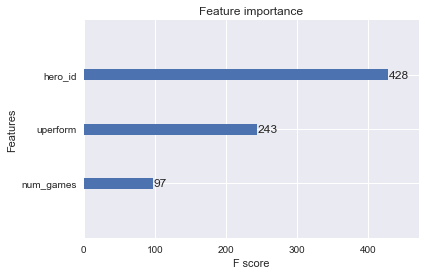

In [18]:
xgb2 = xgb.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=110, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=10,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

xgb2.fit(train9[feato], train9['kda_ratio'])
xgb2predict = xgb2.predict(train1[feato])
xgb.plot_importance(xgb2)
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(train1['kda_ratio'], xgb2predict)))

664.564819801


### Feature set feato gives lowest rmse.

### The feature set feato can be used to create a model for any test sets(9 heroes) and predict for another test set(10th hero).

### Lets create a few more features and test.

In [20]:
### Create a feature whperform = u1 * h11k + u2 * h12k + ...
###                              ---------------------------
###                                 u1 + u2+ .....
### where u1 = average performance of user1, h11k = performance of hero 1 for user 1. 

In [21]:
combitrain = pd.concat([train9, train1, test9])

combitrain.head()

,user_id,hero_id,id,num_games,num_wins,kda_ratio,hperform,uperform,base_health,base_health_regen,...,agility_gain,intelligence_gain,attack_range,projectile_speed,attack_rate,move_speed,turn_rate,primary_attr_int,primary_attr_str,attack_type_Ranged
0,1,74,1_74,304,185,3743.699732,3882.395274,3857.506249,200,1.50,...,1.9,4.0,600,900,1.7,280,0.5,1,0,1
1,1,65,1_65,255,151,4009.021513,3714.702846,3857.506249,200,3.25,...,1.5,2.5,375,900,1.7,290,1.0,1,0,1
2,1,39,1_39,203,135,5094.621514,4290.934368,3857.506249,200,1.50,...,2.0,2.5,550,1500,1.5,295,0.5,1,0,1
3,1,106,1_106,158,106,4619.212963,4646.036396,3857.506249,200,2.00,...,1.8,1.8,150,900,1.7,305,0.5,0,0,0
4,1,2,1_2,157,94,2871.627907,2785.782458,3857.506249,200,4.25,...,2.2,1.6,150,900,1.7,290,0.6,0,1,0


In [22]:
combitrain['temp'] = combitrain.kda_ratio.mul(combitrain.uperform)
temp2 = combitrain.groupby('hero_id')['temp'].sum()
temp3 = combitrain.groupby('hero_id')['uperform'].sum()
temp4 = temp2 / temp3
temp5 = temp2 / temp4
train9['uhperform'] = train9.hero_id.map(temp4)
train1['uhperform'] = train1.hero_id.map(temp4)
test9['uhperform'] = test9.hero_id.map(temp4)
test1['uhperform'] = test1.hero_id.map(temp4)
train9['huperform'] = train9.hero_id.map(temp5)
train1['huperform'] = train1.hero_id.map(temp5)
test9['huperform'] = test9.hero_id.map(temp5)
test1['huperform'] = test1.hero_id.map(temp5)

### Train a model again with this new feature included. Repeat untill satisfactory performance is achieved.

### Train a model for test set.

In [256]:
xgb3 = xgb.XGBRegressor(learning_rate=0.1, nthread=-1)
param_grid = {'n_estimators':[140, 150, 160], 'reg_lambda':[0.01, 1, 10], 'colsample_bytree':[0.7, 1]}


tune(test9, feato, 'kda_ratio', xgb3, param_grid)

-313122.854028 XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=10,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [257]:
xgb4 = xgb.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=150, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=10,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
       

xgb4.fit(test9[feato], test9['kda_ratio'])
predict_kda = xgb4.predict(test1[feato])

In [258]:
out1 = {'id':test1.id, 'kda_ratio':predict_kda}
df = pd.DataFrame(out1)
df.to_csv(r'H:/py/datasets/av/dota/xgb_feato_hero.csv')

### Since interaction between users and heroes are important lets train a neural net.

In [105]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
train91 = train9[['num_games','uperform', 'uhperform', 'huperform', 'hero_id']]
train11 = train1[['num_games','uperform', 'uhperform', 'huperform', 'hero_id']]
test91 = test9[['num_games','uperform', 'uhperform', 'huperform', 'hero_id']]
test11 = test1[['num_games','uperform', 'uhperform', 'huperform', 'hero_id']]

train91.loc[:,['num_games','uperform', 'uhperform', 'huperform']] = ss.fit_transform(train9[['num_games','uperform', 'uhperform', 'huperform']])
train11.loc[:,['num_games','uperform', 'uhperform', 'huperform']] = ss.fit_transform(train1[['num_games','uperform', 'uhperform', 'huperform']])
test91.loc[:,['num_games','uperform', 'uhperform', 'huperform']] = ss.fit_transform(test9[['num_games','uperform', 'uhperform', 'huperform']])
test11.loc[:,['num_games','uperform', 'uhperform', 'huperform']] = ss.fit_transform(test1[['num_games','uperform', 'uhperform', 'huperform']])

train91 = pd.get_dummies(train91, columns=['hero_id'], drop_first=True)
train11 = pd.get_dummies(train11, columns=['hero_id'], drop_first=True)
test91 = pd.get_dummies(test91, columns=['hero_id'], drop_first=True)
test11 = pd.get_dummies(test11, columns=['hero_id'], drop_first=True)
for  i in ex:
    tem = 'hero_id_' + str(i)
    test11.loc[:, tem] = 0
print(train91.columns, train91.shape)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Index(['num_games', 'uperform', 'uhperform', 'huperform', 'hero_id_2',
       'hero_id_3', 'hero_id_4', 'hero_id_5', 'hero_id_6', 'hero_id_7',
       ...
       'hero_id_107', 'hero_id_108', 'hero_id_109', 'hero_id_110',
       'hero_id_111', 'hero_id_112', 'hero_id_113', 'hero_id_114',
       'hero_id_119', 'hero_id_120'],
      dtype='object', length=118) (18846, 118)


In [106]:
# Creating data for neural net
train9_numpy = train91[train91.columns.values].values
train1_numpy = train11[train11.columns.values].values
test9_numpy = test91[test91.columns.values].values
test1_numpy = test11[test11.columns.values].values

In [107]:
#.reshape(18846, 5, 1)
#.reshape(2094, 5, 1)
#.reshape(8082, 5, 1)
#.reshape(898, 5, 1)
test9_numpy.shape

(8082, 118)

In [108]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(50, activation='relu', input_dim=118))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',
              loss='mse')

In [91]:
from keras.callbacks import EarlyStopping

#es = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=1, mode='auto')
model.fit(x=test9_numpy, y=test9.kda_ratio.values, epochs=20, verbose=1)

Epoch 1/20
8082/8082 [==============================] - 1s - loss: 11566213.5754     
Epoch 2/20
8082/8082 [==============================] - 1s - loss: 1325117.3240     
Epoch 3/20
8082/8082 [==============================] - 1s - loss: 409082.7807     
Epoch 4/20
8082/8082 [==============================] - 1s - loss: 370329.3004     
Epoch 5/20
8082/8082 [==============================] - 1s - loss: 350932.3968     
Epoch 6/20
8082/8082 [==============================] - 1s - loss: 339661.7021     
Epoch 7/20
8082/8082 [==============================] - 1s - loss: 331951.4031     
Epoch 8/20
8082/8082 [==============================] - 1s - loss: 326622.0321     
Epoch 9/20
8082/8082 [==============================] - 1s - loss: 322787.5136     
Epoch 10/20
8082/8082 [==============================] - 1s - loss: 318537.0150     
Epoch 11/20
8082/8082 [==============================] - 1s - loss: 317228.0245     
Epoch 12/20
8082/8082 [==============================] - 1s - loss: 315

In [112]:
pd1 = model.predict(test1_numpy)


In [102]:
ex = [x for x in test9.hero_id.unique() if x not in test1.hero_id.unique()]

In [120]:
pd2 = pd1.reshape(898)

In [121]:
import pandas as pds
out1 = {'id':test1.id, 'kda_ratio':pd2}
df = pds.DataFrame(out1)
df.to_csv(r'H:/py/datasets/av/dota/nn.csv')